In [1]:
import math
import torch
from diffusion_edf.dist import sample_igso3

from matplotlib import pyplot as plt

import numpy as np
np.set_printoptions(precision=4, floatmode="fixed")

In [2]:
sample_w_max = sample_igso3(eps=100., N=100000)
sample_w_max = torch.acos(sample_w_max[:,0])*2
sample_w_degree_max = sample_w_max / torch.pi * 180.

$IG_{SO(3)}$ almost converges at $t=6$

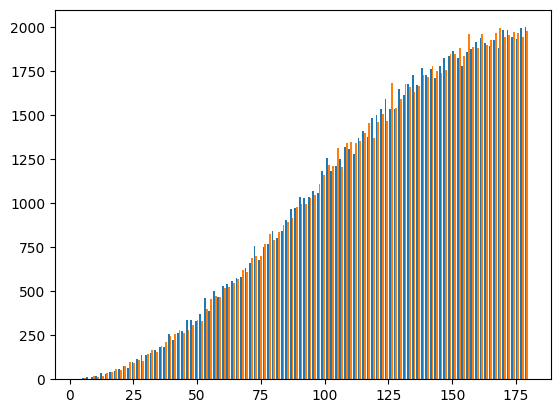

In [3]:
t = 6.
eps = t/2

sample = sample_igso3(eps=eps, N=100000)
sample_w = torch.acos(sample[:,0])*2
sample_w_degree = sample_w / torch.pi * 180.

plt.hist([sample_w_degree, sample_w_degree_max], bins=100)
plt.show()

$\textrm{rotation angle}\ \  w\approx \sqrt{t}\times 38.5\degree$

In [4]:
for t in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]:
    eps = t/2

    sample = sample_igso3(eps=eps, N=100000)
    sample_w = torch.acos(sample[:,0])*2
    sample_w_degree = sample_w / torch.pi * 180.
    print(sample_w.std().item() / math.sqrt(t))
print(f"\n degree: {sample_w_degree.std().item() / math.sqrt(t)}")

0.6736362126239206
0.6738028662803945
0.6741647659614838
0.6756633867274429
0.6756287984730781

 degree: 38.71067867000223


# Play

tensor(3.8781, dtype=torch.float64)


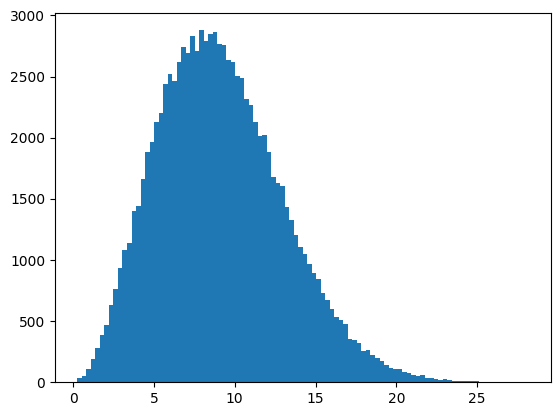

In [5]:
t = 1e-2
eps = t/2

sample = sample_igso3(eps=eps, N=100000)
sample_w = torch.acos(sample[:,0])*2
sample_w_degree = sample_w / torch.pi * 180.
print(sample_w_degree.std())

plt.hist(sample_w_degree, bins=100)
plt.show()

# Calculator

In [6]:
def std_calculator(t_schedule, lin_mult, ang_mult = 1., p = 0.95, N = 100000):
    lin_stds = []
    ang_stds = []
    lin_maxs = []
    ang_maxs = []
    lin_meds = []
    ang_meds = []
    lin_mods = []
    ang_mods = []

    for t in t_schedule:
        eps = t/2 * (ang_mult**2)
        std = torch.tensor([math.sqrt(t*3)]) * lin_mult
        lin_stds.append(std)
        lin_samples = torch.randn(N,3).norm(dim=-1) * std

        sample = sample_igso3(eps=eps, N=N)
        sample_w = torch.acos(sample[:,0])*2
        sample_w_degree = sample_w / torch.pi * 180.
        ang_stds.append(sample_w_degree.std().unsqueeze(0))
        ang_max = sample_w_degree.sort().values[int(p*N)]
        ang_maxs.append(ang_max.unsqueeze(0))
        lin_max = lin_samples.sort().values[int(p*N)]
        lin_maxs.append(lin_max.unsqueeze(0))

        lin_meds.append(lin_samples.median().unsqueeze(0))
        ang_meds.append(sample_w_degree.median().unsqueeze(0))

        boundaries = torch.linspace(0., ang_max*1.2, steps=100)
        bins = torch.bucketize(sample_w_degree, boundaries=boundaries)
        ang_mod = boundaries[bins.mode().values]

        boundaries = torch.linspace(0., lin_max*1.2, steps=100)
        bins = torch.bucketize(lin_samples, boundaries=boundaries)
        lin_mod = boundaries[bins.mode().values]

        lin_mods.append(lin_mod.unsqueeze(0))
        ang_mods.append(ang_mod.unsqueeze(0))

    return torch.cat(lin_stds), torch.cat(ang_stds), torch.cat(lin_maxs), torch.cat(ang_maxs), torch.cat(lin_meds), torch.cat(ang_meds), torch.cat(lin_mods), torch.cat(ang_mods)

In [26]:
lin_stds, ang_stds, lin_maxs, ang_maxs, lin_meds, ang_meds, lin_mods, ang_mods = std_calculator([1e-4, 1e-3, 1e-2, 1e-1, 1.], ang_mult = 2.5, lin_mult=20., p=0.95)

print(f"angular std: {ang_stds.numpy()}")
print(f"angular median: {ang_meds.numpy()}")
print(f"angular mode: {ang_mods.numpy()}")
print(f"angular max: {ang_maxs.numpy()}")
print("========================================")
print(f"linear std: {lin_stds.numpy()}")
print(f"linear median: {lin_meds.numpy()}")
print(f"linear mode: {lin_mods.numpy()}")
print(f"linear max: {lin_maxs.numpy()}")

angular std: [ 0.9634  3.0411  9.6641 29.6485 37.0822]
angular median: [  2.1982   6.9514  21.9383  67.7484 131.8029]
angular mode: [  2.3794   6.1080  20.3768  59.7136 176.4648]
angular max: [  4.0062  12.5978  40.0259 123.1594 175.4017]
linear std: [ 0.3464  1.0954  3.4641 10.9545 34.6410]
linear median: [ 0.5322  1.6909  5.3306 16.8655 53.3415]
linear mode: [ 0.4819  1.4878  5.1513 15.5906 48.1460]
linear max: [ 0.9697  3.0686  9.6587 30.6244 96.8791]


In [30]:
lin_stds, ang_stds, lin_maxs, ang_maxs, lin_meds, ang_meds, lin_mods, ang_mods = std_calculator([1e-4, 5e-4, 5e-3, 3e-2, 1e-1, 1.], ang_mult = 2.5, lin_mult=15., p=0.95)

print(f"angular std: {ang_stds.numpy()}")
print(f"angular median: {ang_meds.numpy()}")
print(f"angular mode: {ang_mods.numpy()}")
print(f"angular max: {ang_maxs.numpy()}")
print("========================================")
print(f"linear std: {lin_stds.numpy()}")
print(f"linear median: {lin_meds.numpy()}")
print(f"linear mode: {lin_mods.numpy()}")
print(f"linear max: {lin_maxs.numpy()}")

angular std: [ 0.9676  2.1572  6.8142 16.5375 29.6057 37.0360]
angular median: [  2.2076   4.8959  15.5188  37.7565  67.8178 132.2334]
angular mode: [  2.0900   4.4416  15.4016  35.7338  58.0901 168.0133]
angular max: [  4.0099   8.9375  28.2362  68.5590 122.8830 175.4569]
linear std: [ 0.2598  0.5809  1.8371  4.5000  8.2158 25.9808]
linear median: [ 0.3995  0.8942  2.8358  6.9056 12.6527 40.0900]
linear mode: [ 0.3608  0.8670  2.4916  6.6871 11.7152 36.0302]
linear max: [ 0.7260  1.6256  5.1389 12.5383 23.0120 72.4997]
